In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
os.chdir("/content/drive/My Drive/colab/ImageStyleTransfer")

In [6]:
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision

from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 均已测试

print(device, torch.__version__)

cuda 1.7.0+cu101


In [7]:
torch.cuda.is_available()

True

In [8]:
!nvidia-smi

Sun Dec 27 07:30:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    14W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

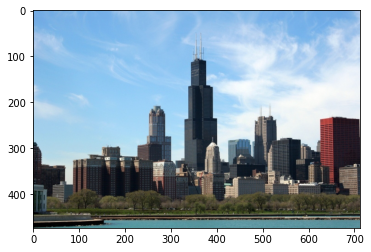

In [9]:
# content_img = Image.open('content.png').convert('RGB')
content_img = Image.open('content/test.jpg').convert('RGB')

plt.imshow(content_img);

<PIL.Image.Image image mode=RGB size=938x640 at 0x7EFF22529CF8>


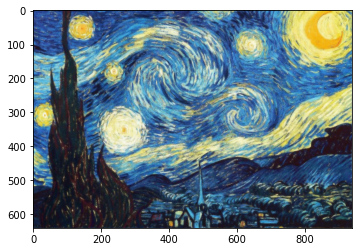

In [10]:
style_img = Image.open('style/denoised_starry.jpg').convert('RGB')

print(style_img)
plt.imshow(style_img);

In [11]:
rgb_mean = np.array([0.485, 0.456, 0.406])
rgb_std = np.array([0.229, 0.224, 0.225])

def preprocess(PIL_img, image_shape):
    process = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])

    return process(PIL_img).unsqueeze(dim = 0) # (batch_size, 3, H, W)

def postprocess(img_tensor):
    inv_normalize = torchvision.transforms.Normalize(
        mean= -rgb_mean / rgb_std,
        std= 1/rgb_std)
    to_PIL_image = torchvision.transforms.ToPILImage()
    return to_PIL_image(inv_normalize(img_tensor[0].cpu()).clamp(0, 1))

In [12]:
pretrained_net = torchvision.models.vgg19(pretrained=True)
# pretrained_net.load_state_dict(torch.load('/root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth'))

In [28]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]
weight_style = [0.5, 1, 1.5, 3, 4]
# weight_style = [1, 1, 1, 1, 1]


In [15]:
net_list = []
for i in range(max(content_layers + style_layers) + 1):
    net_list.append(pretrained_net.features[i])
net = torch.nn.Sequential(*net_list)


In [16]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    j = 0
    for i in range(len(net)):
        X = net[i](X)       
        if i in style_layers:
            styles.append(X*weight_style[j])
            # styles.append(X)

            j += 1
        if i in content_layers:
            contents.append(X)
    return contents, styles

In [17]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

In [18]:
def content_loss(Y_hat, Y):
    return F.mse_loss(Y_hat, Y)

In [19]:
def gram(X):
    num_channels, n = X.shape[1], X.shape[2] * X.shape[3]
    X = X.view(num_channels, n)
    return torch.matmul(X, X.t()) / (num_channels * n)

In [20]:
def style_loss(Y_hat, gram_Y):
    return F.mse_loss(gram(Y_hat), gram_Y)

In [21]:
def tv_loss(Y_hat):
    return 0.5 * (F.l1_loss(Y_hat[:, :, 1:, :], Y_hat[:, :, :-1, :]) + 
                  F.l1_loss(Y_hat[:, :, :, 1:], Y_hat[:, :, :, :-1]))

In [22]:
content_weight, style_weight, tv_weight = 1, 1e3, 10
# content_weight, style_weight, tv_weight = 1.0, 1e5, 100.0

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、样式损失和总变差损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(styles_l) + sum(contents_l) + tv_l
    return contents_l, styles_l, tv_l, l

In [23]:
class GeneratedImage(torch.nn.Module):
    def __init__(self, img_shape):
        super(GeneratedImage, self).__init__()
        self.weight = torch.nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

In [24]:
def get_inits(X, device, lr, styles_Y):
    gen_img = GeneratedImage(X.shape).to(device)
    gen_img.weight.data = X.data
    optimizer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, optimizer

In [25]:
def train(X, contents_Y, styles_Y, device, lr, max_epochs, lr_decay_epoch):
    print("training on ", device)
    X, styles_Y_gram, optimizer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_decay_epoch, gamma=0.0001)
    for i in range(max_epochs):
        start = time.time()
        
        contents_Y_hat, styles_Y_hat = extract_features(
                X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
                X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        
        optimizer.zero_grad()
        l.backward(retain_graph = True)
        optimizer.step()
        scheduler.step()
        
        if i % 50 == 0 and i != 0:
            print('epoch %3d, content loss %.2f, style loss %.2f, '
                  'TV loss %.2f, %.2f sec'
                  % (i, sum(contents_l).item(), sum(styles_l).item(), tv_l.item(),
                     time.time() - start))
    return X.detach()

training on  cuda
epoch  50, content loss 3.49, style loss 2.61, TV loss 0.00, 0.07 sec
epoch 100, content loss 3.05, style loss 1.87, TV loss 0.00, 0.06 sec
epoch 150, content loss 2.85, style loss 1.75, TV loss 0.00, 0.07 sec
epoch 200, content loss 2.77, style loss 1.60, TV loss 0.00, 0.06 sec
epoch 250, content loss 2.72, style loss 1.56, TV loss 0.00, 0.07 sec
epoch 300, content loss 2.69, style loss 1.49, TV loss 0.00, 0.07 sec
epoch 350, content loss 2.63, style loss 1.49, TV loss 0.00, 0.07 sec
epoch 400, content loss 2.61, style loss 1.44, TV loss 0.00, 0.07 sec
epoch 450, content loss 2.62, style loss 1.46, TV loss 0.00, 0.07 sec
epoch 500, content loss 2.60, style loss 1.41, TV loss 0.00, 0.07 sec
epoch 550, content loss 2.54, style loss 1.40, TV loss 0.00, 0.07 sec


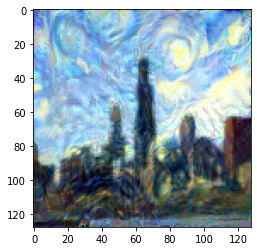

In [ ]:
# image_shape =  (128, 128)
# image_shape = (600, 800)
image_shape =  (512, 512)

net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
style_X, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.1, 500, 5000)

out = postprocess(output)
plt.imshow(out)
# out.save('big2.jpg')

In [ ]:
# image_shape = (300, 450)
# net = net.to(device)
# _, content_Y = get_contents(image_shape, device)
# _, style_Y = get_styles(image_shape, device)
# X = preprocess(postprocess(output), image_shape).to(device)
# big_output = train(X, content_Y, style_Y, device, 0.01, 500, 200)
# bigout = postprocess(big_output)
# plt.imshow(bigout);
# bigout.save('bigout.jpg')

training on  cuda
epoch  50, content loss 2.27, style loss 8.59, TV loss 0.20, 0.64 sec
epoch 100, content loss 2.24, style loss 3.45, TV loss 0.19, 0.64 sec
epoch 150, content loss 2.19, style loss 2.18, TV loss 0.19, 0.65 sec
epoch 200, content loss 2.16, style loss 1.67, TV loss 0.19, 0.64 sec
epoch 250, content loss 2.12, style loss 1.36, TV loss 0.18, 0.64 sec


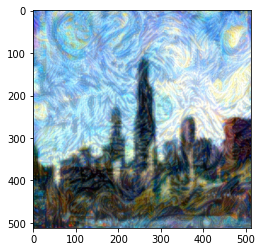

In [ ]:
image_shape = (512, 512)
net = net.to(device)
_, content_Y = get_contents(image_shape, device)
_, style_Y = get_styles(image_shape, device)
X = preprocess(postprocess(output), image_shape).to(device)
big_output = train(X, content_Y, style_Y, device, 0.04, 1000, 5000)
out6x8 = postprocess(big_output)
plt.imshow(out6x8)
out6x8.save('out6x8.jpg')
